## Save single ERA5 timestep as netcdf
* Creates a single netcdf file with initialize date data and forecast date data

In [2]:
from datetime import datetime, timedelta
import os
from typing import List
import xarray as xr
import json
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import sys
sys.path.append(".")  # Add current directory to Python path

In [24]:
# Assign experiment number - this was for my own organization
experiment_number = 1
# Select timestep to save - string format yyyy-mm-ddTHH:MM:SS
timestep_select = '2021-06-27T00:00:00'#'2019-03-22T12:00:00'
# steps are 6-hourly (e.g. 12 steps = 3 days)
n_steps = 12
# Filepath for ERA5 json data
SFNO_dir = "/projectnb/eb-general/shared_data/data/processed/sfno/"
data_fp = os.path.join(SFNO_dir, 'ERA5_SFNO', 'data.json') #"/barnes-engr-scratch2/C837824079/ERA5_SFNO/data.json"

# open initial conditions from stored ERA data
later_str = (datetime.fromisoformat(timestep_select) + timedelta(hours = n_steps*6)).isoformat() 
print(f"Selecting timestep {timestep_select} to {later_str}")

Selecting timestep 2021-06-27T00:00:00 to 2021-06-30T00:00:00


In [17]:
# Utility functions for reading ERA5 data
def filename_to_year(path: str) -> int:
    filename = os.path.basename(path)
    return int(filename[:4])

def datetime_range(
    year: int, time_step: timedelta, n: int
) -> List[datetime]:
    initial_time = datetime(year=year, month=1, day=1)
    return [initial_time + time_step * i for i in range(n)]

def open_hdf5(*, path, f=None, metadata):
    dims = metadata["dims"]
    h5_path = metadata["h5_path"]
    time_step_hours = metadata.get("dhours", 6)
    time_step = timedelta(hours=time_step_hours)

    ds = xr.open_dataset(f or path, engine="h5netcdf", phony_dims="sort")
    array = ds[h5_path]
    ds = array.rename(dict(zip(array.dims, dims)))
    year = filename_to_year(path)
    n = array.shape[0]
    ds = ds.assign_coords(
        time=datetime_range(year, time_step=time_step, n=n), **metadata["coords"]
    )
    ds = ds.assign_attrs(metadata["attrs"], path=path)
    return ds


In [26]:
# Open and load the JSON file
with open(data_fp, 'r') as f:
    labels = json.load(f)

# open initial conditions from stored ERA data
year_of_timestep = datetime.fromisoformat(timestep_select).year
data_create = open_hdf5(path = os.path.join(SFNO_dir, 'ERA5_SFNO',str(year_of_timestep)+'.h5'), metadata = labels)
data_create = data_create.sel(time = [timestep_select, later_str]) # this just selects the first and last time in the time range
data_create = data_create.rename({"channel": "variable"})
data_create


<xarray.DataArray 'fields' (time: 2, variable: 74, lat: 721, lon: 1440)> Size: 615MB
[153659520 values with dtype=float32]
Coordinates:
  * time       (time) datetime64[ns] 16B 2021-06-27 2021-06-30
    grid_type  <U11 44B 'equiangular'
  * lat        (lat) float64 6kB 90.0 89.75 89.5 89.25 ... -89.5 -89.75 -90.0
  * lon        (lon) float64 12kB 0.0 0.25 0.5 0.75 ... 359.0 359.2 359.5 359.8
  * variable   (variable) <U5 1kB 'u10m' 'v10m' 'u100m' ... 'q925' 'q1000'
Attributes:
    description:  ERA5 data at 6 hourly frequency with snapshots at 0000, 060...
    path:         /projectnb/eb-general/shared_data/data/processed/sfno/ERA5_...

## Quick plot to make sure data looks correct for event before saving

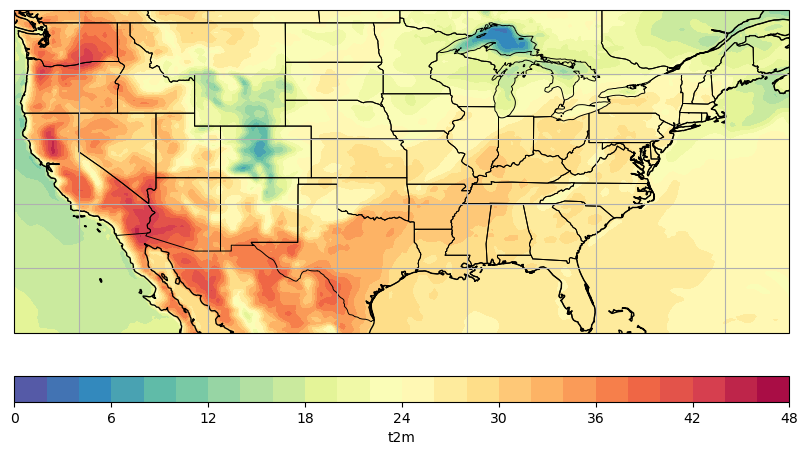

In [32]:
variable = "t2m" #"tcwv" #select variable to plot

if experiment_number == 5: # set lat lon min based on location of event
    lat_min, lat_max = -65, -25
    lon_min, lon_max = 135, 175
else: #conus default
    lat_min, lat_max = 25, 50
    lon_min, lon_max = -125, -65

# Create the plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
if variable == "wind":
    plot_data = np.sqrt(data_create.sel(variable="u10m").isel(time = 1)**2 + data_create.sel(variable="v10m").isel(time = 1)**2)
else:
    plot_data = data_create.sel(variable=variable).isel(time = 0) -273.15 #convert from K to C # this was -1 before

levels = np.arange(0,50,2), #np.arange(990, 1020, 5), #MSL
# Plot the data using contourf
contour = ax.contourf(
    data_create['lon'],
    data_create['lat'],
    plot_data, 
    levels = levels,
    transform=ccrs.PlateCarree(),
    cmap= "Spectral_r",  # You can choose any colormap
)  
ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.STATES, linewidth=0.7)  # Add state lines
fig.colorbar(contour, ax=ax, orientation="horizontal", pad=0.07, aspect=30 , label=variable, )  # Add colorbar

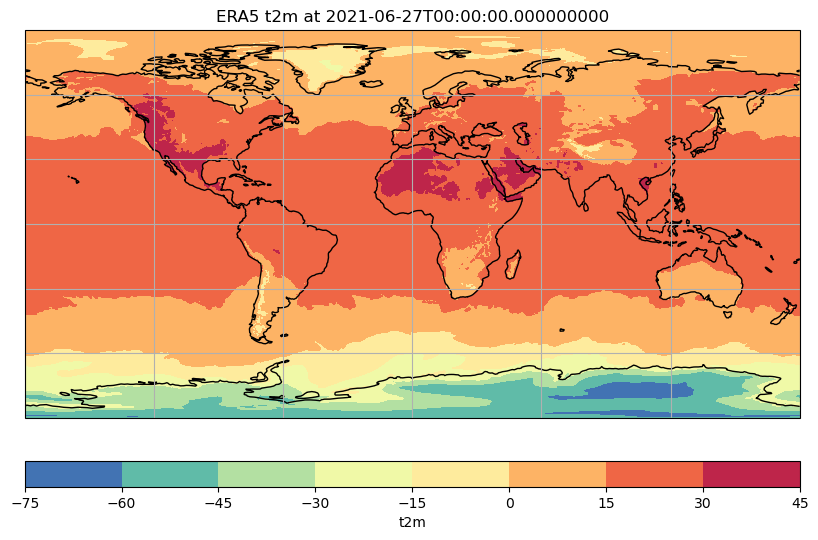

In [ ]:
# Plot globally
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
levels = None #  np.arange(0,50,5), # np.arange(990, 1020, 5), #MSL # None for automatic

contour = ax.contourf(
    data_create['lon'],
    data_create['lat'],
    plot_data, 
    levels = levels,
    transform=ccrs.PlateCarree(),
    cmap= "Spectral_r",  # You can choose any colormap
)
ax.set_title(f"ERA5 {variable} at {data_create['time'].values[0]}")
ax.coastlines()
ax.gridlines()
fig.colorbar(contour, ax=ax, orientation="horizontal", pad=0.07, aspect=30 , label=variable)  # Add colorbar

plt.show()



## Save

In [ ]:
# output_fp = f"./Experiment{experiment_number}/Initialize_data/Initialize_{datetime.fromisoformat(timestep_select).strftime("%Y_%m_%dT%H")}_nsteps{n_steps}.nc"#f"/barnes-engr-scratch2/C837824079/Experiment{experiment_number}/Initialize_data/Initialize_{datetime.fromisoformat(timestep_select).strftime("%Y_%m_%dT%H")}_nsteps{n_steps}.nc"
# data_create.to_netcdf(output_fp)